# What is the fastest possible volleyball serve?

I started off by giving the ball a single bounce off the floor, then a small spin throw in my hands, getting a feel for the ball. I then hold it up straight in front of me in my left hand, with my right hand at eye-level as if pulling on a bow-string. I throw the ball straight up, and start accelerating my right hand, twisting my upper body for maximum velocity. My hand strikes the ball, producing a satisfying bang, sending the ball flying through the air. It flies majestically, spinning like a ballerina, morphing into a blue and yellow blur of exellence. Then it hits the net, becoming entagled in disaster. Their serve.

Filip is given the ball. He goes through the same motions, he's the one I've been copying after all. But Mozart would always be the best at playing Mozart. He hits the ball at blistering speeds, I yell "Got it!", but I didn't have it. Not even in the slightest. It hits my forearm, then the floor. Then the shame hits, hurting far more.

It's been a few years since I played volleyball with Filip, but I'd guess he's still way better than me. However, should we ever meet again on the court, I'd have computational physics on my side. That might not help at all, due to my lack of talent. But there's only one way to find out, by trying to find the fastest possible serve.

To do the calculations I will use numpy. And to show my results I will use matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The Rules

When I say "the fastest possible serve", what I mean is the serve that takes the least amount of time to reach the opponents floor, to give my opponent the least amount of time possible to react to my serve.

Before I tackle the problem, I'll need to define some parameters as the court, net, ball and air will affect the serve. Information about the court, net and ball are given by the <a href="https://www.fivb.org/EN/Refereeing-Rules/documents/FIVB-Volleyball_Rules_2017-2020-EN-v06.pdf">FIVB</a>.

A volleyball court is 18m by 9m, and the net has a height of 2.43m, standing tall in the middle of the court. The ball weighs 270g, and has a radius of 10,5cm.

In [2]:
outX = 18
netX = 9
netheight = 2.43
ballmass = 0.265
radius = 0.105
A = np.pi * radius**2 #Cross sectional area

## The forces acting on the ball

### Gravity

Throughout the serve, gravity will apply a constant force on the ball, pulling it down. At sea level, the force is given by $G = mg$, with $m$ being the mass of the ball, and $g$ being the standard acceleration due to gravity. Newtons second law gives us that force equals mass times acceleration, which means that:

$$F = ma \Rightarrow a = \frac{F}{m} = \frac{G}{m} = \frac{mg}{m} = g$$

This means that gravity will constantly give an acceleration of $g = 9.81 m/s^2$ downward.

In [3]:
g = [0, -9.81]

### Air Resistance

When the ball moves through the air, it has to move away the air in front of it. When the ball pushes away the air, the air pushes the ball back, slowing the ball down. How much the ball is pushed back relies on the velocity of the ball, the size of the ball, the density of the air and something called the drag coefficient of the ball. The drag coefficient of objects is normally found experimentally. I will be using the drag coefficient found by the brilliant people at <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.176.6783&rep=rep1&type=pdf">Hope College</a> when solving a similar problem to mine.

Drag acts in the direction opposite of the velocity of the ball, and is at high velocities given by:

$$\vec{F}_{Drag} = -\frac{1}{2}\vec{v}^2\rho C_d A$$

where $\vec{v}$ is the velocity and $C_d$ is the drag coefficient.

In [4]:
rho = 1.225 #The density of the air
Cd = 0.36 #Drag coefficient of a volleyball
def drag(v):
    return -0.5 * v * np.linalg.norm(v) * rho * Cd * A

### Spin - The Magnus Effect

When the ball flies through the air, air is flowing past the ball. If the ball has top-spin, the top of the ball will move along the direction of the ball, pushing air in the direction opposite of the flow. This will make air accumulate at the top of the ball. On the bottom of the ball, the spinning of the ball will simply push the air in the same direction as the flow.

This means that air will accumulate at the top of the ball, but not at the bottom. This will result in a difference in pressure, which will push the ball downward.

This downward force due to spin will be beneficial to my perfect serve, as it will make the ball move faster toward the ground. This force due to spin relies on the angular velocity, velocity, cross-sectional area and radius of the ball, as well as something called the spin coefficient. Again, this value is normally found experimentally, and I will again use the results found by Hope College for my calculation.

The force due to spin is perpendicular to the velocity of the ball, and is given by:

$$\vec{F}_{Spin} = \frac{1}{2}\vec{\omega} \times \vec{v} C_s \rho A r$$

where $\vec\omega$ is angular velocity and $C_s$ is the spin-coefficient.

In [5]:
spinCoef = 0.30
def spinDrag(v, angvel):
    return 0.5 * spinCoef * rho * A * radius * angvel * np.array([v[1], -v[0]])

## Server constants

I'll need to put some constraints on the model, as I can't jump all the way to the net and smash the volleyball through Filip's face at the speed of light. The values I set as my limitations will be my guesses at what a professional volleyball player can acheive.

In [6]:
startingPos = [0.5, 2.5] #I hit the ball 0.5m into the court, at a height of 2.5m
angvel = 7*2*np.pi #7 revolutions/second, I have no idea what is realistic
maxVel = 36 #m/s, close to the highest ever recorded
maxAngle = np.pi/2 #pi/2 radians, 90 degrees

This leaves me with three values to find. Starting velocity, angle upward and angle to the left. Before I try to find the combination of these three values that give me the perfect serve, I will do the computation for a serve with some arbitrary values instead to see what happens.

## Computing a serve

First I define the number of loops and the time-step for the Euler-Cromer calculation.

Here I define the starting velocity and angle as two arbitrary numbers that give me a good serve.

Now I need to do two things: Calculate the movement of the ball, and find when the ball hits the ground, the net or goes out of bounds. Calculating the movement is done with the Euler-Cromer method.

To make sure that the serve is valid, I will need to constantly check if the ball is where it should be. A serve is successful if it hits the ground behind the net. However, if it collides with the net, or is directly under the net during the serve, it is invalid. Hitting the ground too early or too late will also invalidate the serve.

In [7]:
def serve(startingVel, startingAng, n, dt):
    v = np.array([startingVel*np.cos(startingAng), startingVel*np.sin(startingAng)])
    p = np.empty((num,2))
    p[:] = np.nan #Makes the position array empty so that the (0,0)-position donesn't show up on the plot
    p[0] = startingPos
    
    for i in range(n):
        a = g + drag(v)/ballmass + spinDrag(v, angvel)/ballmass
        v = v + a*dt
        p[i+1] = p[i] + v*dt
        
        distance = p[i+1][0]
        height = p[i+1][1]
        if (distance < outX and height < radius and distance > netX + 0.5):
            #It hit the ground on the other side of the net
            return(p, i * dt)
        if (distance > outX or height < radius):
            #It's out or it hit the ground or my side
            return(None, None)
        if ((p[i][0] <= netX <= distance) and height < netheight + radius):
            #It's below the net
            return(None, None)

In [8]:
num = 2000
timestep = 0.001
v0 = 16 #m/s
theta0 = 0.32 #starting angle in radians
position = serve(v0, theta0, 2000, 0.001)[0]

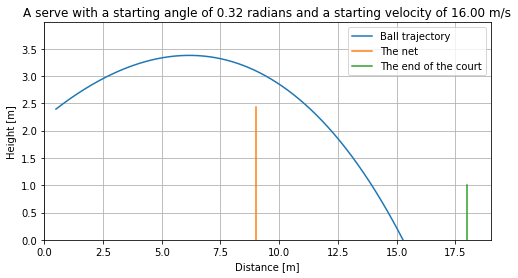

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(position[:, 0], position[:, 1] - radius, label="Ball trajectory")
plt.xlim(0, outX + 1)
plt.ylim(0, np.nanmax(position[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.plot([18,18],[0,1], label="The end of the court")
plt.grid()
plt.legend(loc="upper right")

plt.title("A serve with a starting angle of {:.2f} radians and a starting velocity of {:.2f} m/s".format(theta0, v0))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")
plt.show()

Now that I have the tools to simulate a serve and see if it was valid, it's time to see how the starting speed and angle affect the trajectory.

## Finding the effect of changing speed and angle

I'll use my example serve as a starting off point and see what happens if I change the angle of the serve, and then the velocity.

### Changing angle

My intuition tells me that I'll want to go for as low an angle as possible, as that will make the arch of the ball lower, and therefore make the journey from the air to the ground as short as possible. By keeping the velocity steady at 16m/s and calculationg the time it would take for a serve at any angle between 0 and $\pi$/2 radians (0 and 90 degrees) I can see what difference changing the angle makes to the total time of the serve.

In [10]:
thetas = np.linspace(0, np.pi/2, 100)
thetime = np.empty(100)
thetime[:] = np.nan
n = 2000
dt = 0.005
constVel = 16

for i in range(len(thetas)):
    theta = thetas[i]
    thetime[i] = serve(constVel, theta, n, dt)[1]

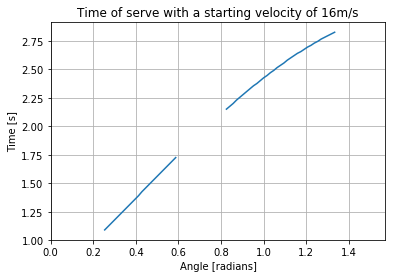

In [11]:
plt.plot(thetas, thetime)
plt.xlim(0,np.pi/2)
plt.grid()
plt.title("Time of serve with a starting velocity of 16m/s")
plt.xlabel("Angle [radians]")
plt.ylabel("Time [s]")
plt.show()

It looks like my intuition was right, lower angle means shorter total time. I see that a small change in angle can mean a large change in total time, which means that optimizing the angle of the serve is very beneficial for getting faster serves.  But there is a limit to how low the ball can be served, I see that the graph cuts off at about 0.25 radians at the optimal time of about 1.1 seconds.

The graph gets cut off in the middle, due to the ball flying too far. With very large angles, the ball starts landing inside the court again, though the serve becomes quite slow at that point.

### Changing velocity

To see how velocity changes the total time, I'll do the same as with the angles. With a constant angle og 0.32 radians I will calculate the time it takes for a serve at any velocity between 10 and 36m/s(the maximum velocity).

In [12]:
vels = np.linspace(10, maxVel, 100)
veltime = np.empty(100)
veltime[:] = np.nan
n = 2000
dt = 0.005
constAngle = 0.32

for i in range(len(vels)):
    vel = vels[i]
    veltime[i] = serve(vel, constAngle, n, dt)[1]

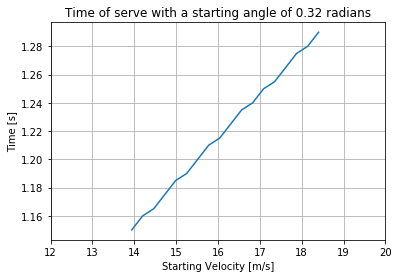

In [13]:
plt.plot(vels,veltime)
plt.xlim(12,20)
plt.grid()
plt.title("Time of serve with a starting angle of 0.32 radians")
plt.xlabel("Starting Velocity [m/s]")
plt.ylabel("Time [s]")
plt.show()

This isn't as intuitive. Lower starting velocity leads to faster serves. An important caveat here is that the angle is constant though. The lowest speed leads to the lowest trajectory, which again reduces the distance from the ball to the ground. With the result for changing angle and for changing velocity, it seems like the best strategy is reaching as low an angle as possible, and then finding the lowest possible speed for that angle.

## Finding the fastest possible serve

So far I have changed the velocity and angle seperately for a pretty average serve, to see what impact the changes make on the total time of the serve. However, to find the fastest possible serve I will need to find the combination of angle and velocity that results in the lowest possible time.

To find the best possible combination I will calculate an entire array of possible combinations and then find the fastest. There are more sophisticated methods to optimize two variable funcions, but the brute force method will suffice here.

In [14]:
dim = 80
velocities = np.linspace(10, maxVel,dim) #All of the velocities I will try out
angles = np.linspace(0, np.pi/2, dim) #All of the angles I will try out

time = np.empty((dim, dim)) #The time each valid serve takes
time[:] = np.nan

In [15]:
n = 200
dt = 0.025

for j in range(len(velocities)):
    vel0 = velocities[j]
    for k in range(len(angles)):
        angle = angles[k]
        time[k][j] = serve(vel0, angle, n, dt)[1] #Saving the time the serve takes for later analysis

### The perfect combination of angle and velocity

With the calculation of the serves belonging to many combinations of velocity and angles complete, all that's left to do is analyze the results and find the perfect combination.

First I'll make a contour plot of the combinations and complementary times to show how angle and velocity change the total time of the serve, as well as to show what combinations result in a successful serve.

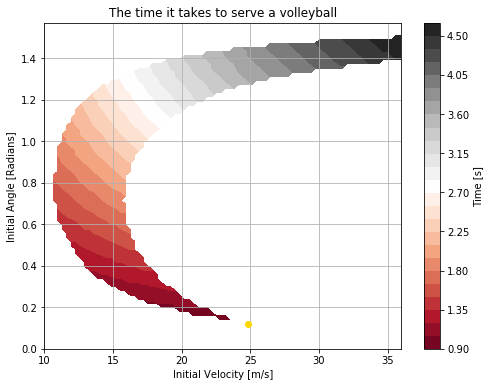

In [16]:
X, Y = np.meshgrid(velocities, angles)

plt.figure(figsize=(8, 6))
ax = plt.contourf(X, Y, time, 25, cmap='RdGy')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time [s]')

result = np.where(time == np.nanmin(time))
bvel = velocities[result[1][0]] #Best velocity
btheta = angles[result[0][0]] #Best angle
plt.plot(bvel,btheta,'o',color='#FFD700') #The yellow point on the plot

plt.grid()
plt.title("The time it takes to serve a volleyball")
plt.xlabel("Initial Velocity [m/s]")
plt.ylabel("Initial Angle [Radians]")
plt.show()

Every possible serve exists on a band which curves from high angle and high velocity(grey area), around low velocity medium angle(pink area), and ends with a sharp point at low angle, high velocity(red area, yellow dot). The yellow dot represents the optimal serve. Around the optimal serve, there are so few possible serves that they don't show up on the plot at all. As one would expect, there is little room for error around the optimal serve, a slight change in velocity or angle, and the serve goes straight in the net or over the court.

In [17]:
print("""The fastest possible serve has a starting angle of {:.2f} radians, a starting velocity of {:.2f} m/s,
and takes {:.2f} seconds.""".format(btheta, bvel, np.nanmin(time)))

The fastest possible serve has a starting angle of 0.12 radians, a starting velocity of 24.81 m/s,
and takes 0.90 seconds.


### The Fastest Possible Serve

With the best starting angle and velocity, I can plot the fastest possible serve.

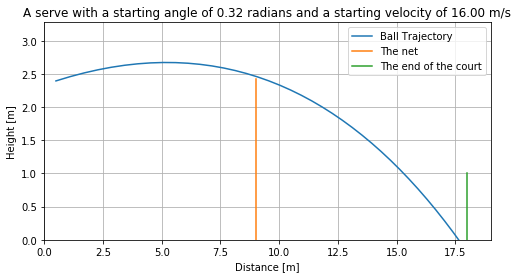

In [18]:
n = 200
dt = 0.025
bpos = serve(bvel, btheta, n, dt)[0]

plt.figure(figsize=(8, 4))
plt.plot(bpos[:, 0], bpos[:, 1] - radius, label="Ball Trajectory")
plt.xlim(0, 18 + 1)
plt.ylim(0, np.nanmax(bpos[:,1])+0.5)

plt.plot([9,9],[0,netheight], label="The net")
plt.plot([18,18],[0,1], label="The end of the court")
plt.grid()
plt.legend(loc="upper right")

plt.title("A serve with a starting angle of {:.2f} radians and a starting velocity of {:.2f} m/s".format(theta0, v0))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")
plt.show()

plt.show()

There it is, the fastest possible serve. Flying only centimetres over the net, and landing right at the edge of the court, this serve leaves the minimal amount of time to react. With this newfound knowledge in my arsenal I am ready to claim my revenge against Filip.

## Sources and inspiration

Optimizing a Volleyball Serve - Hope College Mathematics REU Summer 06 - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.176.6783&rep=rep1&type=pdf

The Magnus Effect - https://en.wikipedia.org/wiki/Magnus_effect

Volleyball Rules - https://www.fivb.org/EN/Refereeing-Rules/documents/FIVB-Volleyball_Rules_2017-2020-EN-v06.pdf